# Детектирование объектов на спутниковом изображении с использованием характерных признаков Хаара
Работа выполнена в рамках лабораторной работы по дисциплине Цифровая обработка изображений.

Задание на лабораторную работу заключается в разработке программы, детектирующей определённый объект в соответствии с вариантом (в моём случае это **крыша дома**) при помощи классификатора, основанного на характерных признаках Хаара.

Для выполнения задачи следует выбрать один из представленных датасетов:
* https://github.com/chrieke/awesome-satellite-imagery-datasets

Конкретно выбранный датасет:
* https://project.inria.fr/aerialimagelabeling/

По ссылке можно найти 5 архивов общим весом около 20-ти ГБ. Я распакую их вне репозитория, чтобы не занимать место и возьму только некоторые из этих изображений для этой работы.

In [1]:
import numpy as np

from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import blob_dog
from skimage.transform import rescale

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pathlib import Path
import json
import pickle

import random

# 1. Создание выборки основных изображений
В данном разделе будут выбраны данные, с которыми далее будет проведена работа.

## 1.1. Инициализация путей
`original_dataset_path` - путь до полного датасета. Его структура следующая:
```
data/
+-- train/
|   +-- images/
|   |   +-- [Список зображений формата *.tif] - Оригинальные изображения
|   +-- gt/
|   |   +-- [Список зображений формата *.tif] - Разметка изображений
+-- test/
    +-- images/
        +-- [Список зображений формата *.tif] - Оригинальные изображения
```

In [2]:
# Пути до оригинального датасета
original_dataset_path = Path("D:\Datasets\Inria Aerial Image\data")
original_dataset_train_path = original_dataset_path / "train"
original_dataset_test_path  = original_dataset_path / "test"
original_dataset_train_img_path = original_dataset_train_path / "images"
original_dataset_train_gt_path  = original_dataset_train_path / "gt"

# Пути до локальных данных
path_data = Path("./data/L3")
path_train = path_data / "train"
path_train_imgs = path_train / "images"
path_train_refs = path_train / "references"

In [3]:
# Создадим папки, если их ещё нет
path_train_imgs.mkdir(parents=True, exist_ok=True)
path_train_refs.mkdir(parents=True, exist_ok=True)

## 1.2. Выборка изображений из изначального датасета
Для данной работы полная выборка изображений избыточна, поэтому выберем только некоторые из изображений и сохраним их локально в репозитории.

Возьмём только изображения из Остина (Техас), т.к. в разных городах дома разного типа, что в рамках данной работы избыточно усложняет задачу. ИСкать будем частные дома.

In [4]:
# Составим полный список изображений
origin_all_imgs = [path.name for path in original_dataset_train_img_path.glob("austin*")]

print(f"Общее количество изображений: {len(origin_all_imgs)}")

Общее количество изображений: 36


In [5]:
# Обеспечение повторяемости эксперимента
random.seed(42)

# Выберем из полного списка ограниченное количество изображений
IMAGE_NUMBER = 5
origin_names = random.sample(origin_all_imgs, IMAGE_NUMBER)

print(f"Следующие {IMAGE_NUMBER} изображений были выбраны:")
for img_name in origin_names:
    print(f"\t{img_name}")

Следующие 5 изображений были выбраны:
	austin16.tif
	austin10.tif
	austin25.tif
	austin23.tif
	austin22.tif


In [6]:
# Скопируем эти изображения в репозиторий
for img_name in origin_names:
    # Пути до оригинальных изображений
    src_img = original_dataset_train_img_path / img_name
    src_ref = original_dataset_train_gt_path / img_name

    # Пути до локальных изображений
    dest_img = path_train_imgs / img_name
    dest_ref = path_train_refs / img_name

    # Проверим существование файла
    if dest_img.exists() and dest_ref.exists():
        continue

    # Выполняем копирование
    dest_img.write_bytes(src_img.read_bytes())
    dest_ref.write_bytes(src_ref.read_bytes())

In [7]:
# Чтобы каждый раз не открывать файлы изображений, сохраним их в переменные
origin_imgs = []
origin_refs = []

for img_name in origin_names:
    # Пути до локальных файлов
    img_path = path_train_imgs / img_name
    ref_path = path_train_refs / img_name

    # Сами изображения
    img = Image.open(img_path)
    ref = Image.open(ref_path)

    # Добавим из в списки, приведя к типу ndarray
    origin_imgs.append(np.array(img))
    origin_refs.append(np.array(ref))

## 1.3. Перевод изображения в Ч-Б

In [8]:
origin_gray = [rgb2gray(img) for img in origin_imgs]

## 1.4. Отображение изображений

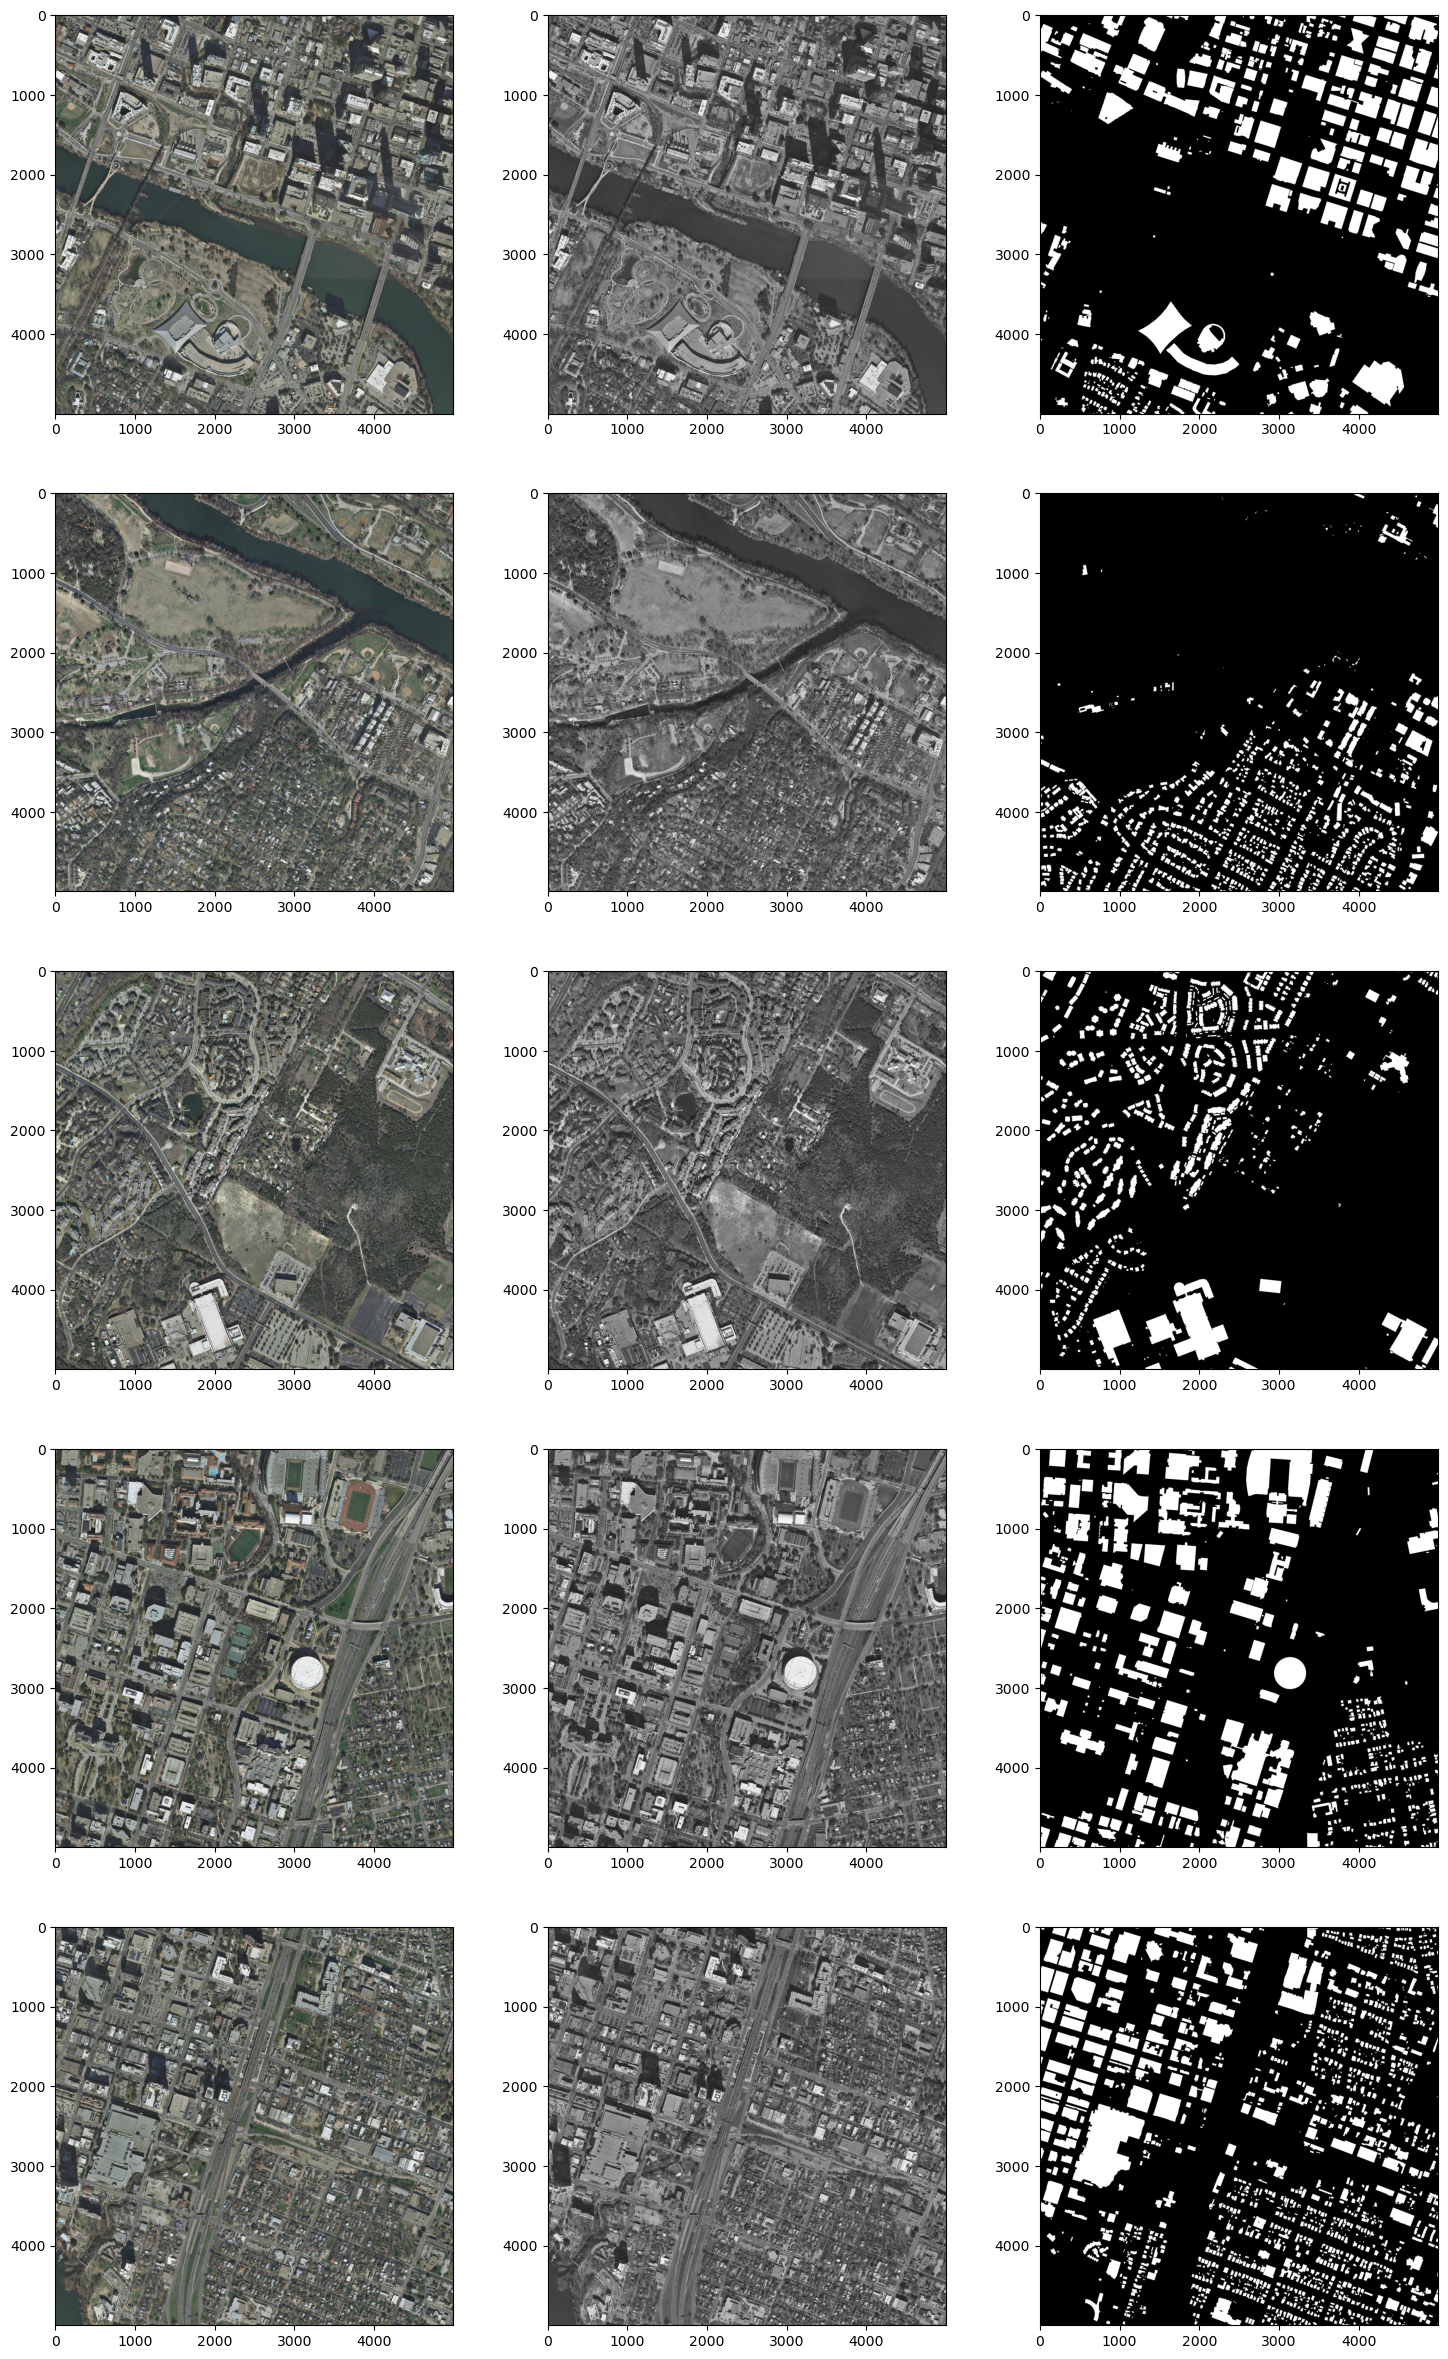

In [9]:
# Отобразим эти изображения
fig, axes = plt.subplots(IMAGE_NUMBER, 3, figsize=(18, 6 * IMAGE_NUMBER))

for axes_row, img, gray, ref in zip(axes, origin_imgs, origin_gray, origin_refs):
    axes_row[0].imshow(img)
    axes_row[1].imshow(gray, cmap="gray")
    axes_row[2].imshow(ref, cmap="gray")

# 2. Исследование данных
В данном разделе выясним особенности выбранных изображений.

## 2.1. Проверка размерности изображений
Изображения зачастую имеют различную размерность. Проверим этот момент.

In [10]:
print("Размерности оригинальных изображений.")
for img, name in zip(origin_imgs, origin_names):
    print(f"Изображение {name:>13}: {img.shape}")
print()
print("Размерности Ч-Б изображений.")
for gray, name in zip(origin_gray, origin_names):
    print(f"Изображение {name:>13}: {gray.shape}")
print()
print("Размерности разметки изображений.")
for ref, name in zip(origin_refs, origin_names):
    print(f"Изображение {name:>13}: {ref.shape}")

Размерности оригинальных изображений.
Изображение  austin16.tif: (5000, 5000, 3)
Изображение  austin10.tif: (5000, 5000, 3)
Изображение  austin25.tif: (5000, 5000, 3)
Изображение  austin23.tif: (5000, 5000, 3)
Изображение  austin22.tif: (5000, 5000, 3)

Размерности Ч-Б изображений.
Изображение  austin16.tif: (5000, 5000)
Изображение  austin10.tif: (5000, 5000)
Изображение  austin25.tif: (5000, 5000)
Изображение  austin23.tif: (5000, 5000)
Изображение  austin22.tif: (5000, 5000)

Размерности разметки изображений.
Изображение  austin16.tif: (5000, 5000)
Изображение  austin10.tif: (5000, 5000)
Изображение  austin25.tif: (5000, 5000)
Изображение  austin23.tif: (5000, 5000)
Изображение  austin22.tif: (5000, 5000)


Тем самым мы убедились, что размерности изображений одинаковы.

## 2.2. Проверка типов изображений
Так как далее будут вычисляться и использоваться интегрированные изображения, то стоит заранее убедиться в том, что типы массивов `ndarray` подходят для этого.

In [11]:
print("Типы оригинальных изображений.")
for img, name in zip(origin_imgs, origin_names):
    print(f"Изображение {name:>13}: {img.dtype}")
print()
print("Типы Ч-Б изображений.")
for gray, name in zip(origin_gray, origin_names):
    print(f"Изображение {name:>13}: {gray.dtype}")
print()
print("Типы разметки изображений.")
for ref, name in zip(origin_refs, origin_names):
    print(f"Изображение {name:>13}: {ref.dtype}")

Типы оригинальных изображений.
Изображение  austin16.tif: uint8
Изображение  austin10.tif: uint8
Изображение  austin25.tif: uint8
Изображение  austin23.tif: uint8
Изображение  austin22.tif: uint8

Типы Ч-Б изображений.
Изображение  austin16.tif: float64
Изображение  austin10.tif: float64
Изображение  austin25.tif: float64
Изображение  austin23.tif: float64
Изображение  austin22.tif: float64

Типы разметки изображений.
Изображение  austin16.tif: uint8
Изображение  austin10.tif: uint8
Изображение  austin25.tif: uint8
Изображение  austin23.tif: uint8
Изображение  austin22.tif: uint8


Тип `uint8` не подойдёт для интегрированного изображения, т.к. быстро переполнится. Это надо будет учитывать.

Тип `float64` может свидетельствовать о переводе изображения в масштаб `[0, 1]`. Проверим это.

In [12]:
print("Диапазон значений в Ч-Б изображениях.")
for gray, name in zip(origin_gray, origin_names):
    print(f"Изображение {name:>13}: {[gray.min(), gray.max()]}")

Диапазон значений в Ч-Б изображениях.
Изображение  austin16.tif: [0.0, 1.0]
Изображение  austin10.tif: [0.0, 1.0]
Изображение  austin25.tif: [0.0, 1.0]
Изображение  austin23.tif: [0.0, 1.0]
Изображение  austin22.tif: [0.0, 1.0]


Так и есть. Это тоже учтём при предобработке.

# 3. Предобработка изображений
Для признаков Хаара следует сформировать интегральные изображения из изначальных чёрно-белых.

## 3.1. Возврат Ч-Б изображения к целочисленному типу
Как было выяснено выше, диапазон значений пикселей сейчас равен `[0.0, 1.0]`. Его следует обратно привести к целочисленному типу для ускорения вычислений.

Изначально значений были в диапазоне `[0, 255]`. Тогда сначала приведём к этому диапазону само изображение.

In [13]:
origin_gray_int = [(gray * 255).astype(np.uint8) for gray in origin_gray]

for gray_int, name in zip(origin_gray_int, origin_names):
    print(f"Изображение {name:>13} : тип - {gray_int.dtype}, диапазон значений: {[gray_int.min(), gray_int.max()]}")

Изображение  austin16.tif : тип - uint8, диапазон значений: [0, 255]
Изображение  austin10.tif : тип - uint8, диапазон значений: [0, 255]
Изображение  austin25.tif : тип - uint8, диапазон значений: [0, 255]
Изображение  austin23.tif : тип - uint8, диапазон значений: [0, 255]
Изображение  austin22.tif : тип - uint8, диапазон значений: [0, 255]


Для изображения размером `5000 x 5000` пикселей и диапазоном значений `[0, 255]` интегральная сумма будет варьироваться в диапазоне `[0, 6375000000]`. Проверим типы, подходящие для этого.

In [14]:
max_integral_value = 5000 * 5000 * 255
print(f"Потенциальный диапазон значений: {[0, max_integral_value]}")

print()
print(np.iinfo('int32'))
print(f"{max_integral_value} {'<' if max_integral_value < np.iinfo('int32').max else '>'} {np.iinfo('int32').max}")

print()
print(np.iinfo('uint32'))
print(f"{max_integral_value} {'<' if max_integral_value < np.iinfo('uint32').max else '>'} {np.iinfo('uint32').max}")

print()
print(np.iinfo('int64'))
print(f"{max_integral_value} {'<' if max_integral_value < np.iinfo('int64').max else '>'} {np.iinfo('int64').max}")

Потенциальный диапазон значений: [0, 6375000000]

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

6375000000 > 2147483647

Machine parameters for uint32
---------------------------------------------------------------
min = 0
max = 4294967295
---------------------------------------------------------------

6375000000 > 4294967295

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------

6375000000 < 9223372036854775807


Итого, выбираем тип `int64`.

## 3.2. Перевод в интегральное изображение

In [15]:
def convert_to_integral(img : np.ndarray, img_type : np.dtype = np.int64) -> np.ndarray:
    """
    Эта функция переводит изображение в интегральную форму.

    Параметры
    ---------
    img : np.ndarray
        Преобразуемое изображение.
    img_type : np.dtype
        Тип, к которому будет приведено изображение перед вычислением.

    Возвращаемое значение
    ---------------------
    integral_image : np.ndarray
        Изображение в интегральной форме.
    """
    return img.astype(img_type).cumsum(axis=0).cumsum(axis=1)

In [16]:
origin_integral = []
for img in origin_gray_int:
    origin_integral.append(convert_to_integral(img))

# 4. Формирование обучающей выборки
Следует определить размер окна для характерных признаков Хаара такой, чтобы, в среднем, дом помещался в это окно целиком.

После этого следует на основе референсных изображений вырезать из основных изображений изображения с домами по центру и сформировать из них обучающую выборку.

На используемых изображениях довольно много домов, их конкретных координат нет - только области. Поэтому я принял решение на основе этих областей найти конкретные дома при помощи блобов.

В библиотеке `skimage` имеется три функции поиска блобов:
* `blob_log` - классическая функция поиска блобов. Ищет светлые блобы на тёмном фоне.
* `blob_dog` - более быстрая версия первой функции.
* `blob_doh` - самый быстрый вариант, однако ищет ещё и тёмные блобы на светлом фоне.

Т.к. понадобится провести некоторые тесты с различными параметрами, чтобы найти наиболее удачное их сочетание, то быстродействие сильно поможет. Однако нас интересуют только светлые блобы на тёмном фоне в силу того, что именно белым цветом на тёмном фоне размечены дома на референсных изображениях. Всё это приводит нас к тому, что лучший выбор для данной задачи - `blob_dog`.

## 4.1. Подбор параметров функции поиска блобов
В данном разделе попробуем найти наиболее эффективный вариант парметров поиска блобов.

In [38]:
blobs_dog_10_100_03_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=100, threshold=0.3, overlap=0.0)

In [40]:
blobs_dog_10_500_03_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=500, threshold=0.3, overlap=0.0)

In [42]:
blobs_dog_10_500_02_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=500, threshold=0.2, overlap=0.0)

In [46]:
blobs_dog_10_500_05_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=500, threshold=0.5, overlap=0.0)

In [48]:
blobs_dog_10_500_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=500, threshold=0.4, overlap=0.0)

In [61]:
blobs_dog_10_500_11_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=500, sigma_ratio=1.1, threshold=0.4, overlap=0.0)

In [65]:
blobs_dog_10_300_20_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=300, sigma_ratio=2.0, threshold=0.4, overlap=0.0)

In [67]:
blobs_dog_10_300_16_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=300, sigma_ratio=1.6, threshold=0.4, overlap=0.0)

In [72]:
blobs_dog_10_200_16_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=200, sigma_ratio=1.6, threshold=0.4, overlap=0.0)

In [80]:
blobs_dog_10_200_18_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=200, sigma_ratio=1.8, threshold=0.4, overlap=0.0)

In [82]:
blobs_dog_10_200_17_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=200, sigma_ratio=1.7, threshold=0.4, overlap=0.0)

In [136]:
blobs_dog_10_200_19_04_00 = blob_dog(origin_refs[0], min_sigma=10, max_sigma=200, sigma_ratio=1.9, threshold=0.4, overlap=0.0)

**Выводы**, к которым я пришёл:
1. Т.к. я ищу конкретные дома и мне не нужно, чтобы несколько координат указывали на один и тот же дом, то следует выставить паксимальное перекрылие блобов `overlap` в `0`.
2. Минимальное сигма должно быть маленьким, чтобы частные дома успешно проходили поиск.
3. Максимальное сигма должно быть большим, чтобы большие дома отмечались большими блобами, а маленькие блобы в них исчезали из-за параметра перекрытия.
4. Чем выше пороговое значение `threshold`, тем менее вероятно, что углы большого дома будут отмечены блобом малого размера.
5. Начиная с порогового значения около `0.5` блобы перестают отмечать частные дома.
6. Оптимальное пороговое значение находится в районе `0.4`.
7. Чем больше максимальное сигма, тем больше времени занимет вычисление блобов. Поэтому следует найти минимальное значение для этого пармаетра, при котором большие дома продолжают определяться большими блобами без маленьких блобов на углах. Это значение находится в районе `200`.
8. Чем выше `sigma_ratio`, тем сильнее блоб должен совпадать с размерами дома. При высоких значениях блобы не будут появляться ка краях вытянутых домов, но и, в целом, домов будет детектироваться меньше.
9. Оптимальное значение `sigma_ratio` находится в районе `1.9`. При этом значении выделяется довольно мало частных домов в сравнеии с меньшими значениями этого параметра, однако, что более важно, практически не выделяются края больших домов.

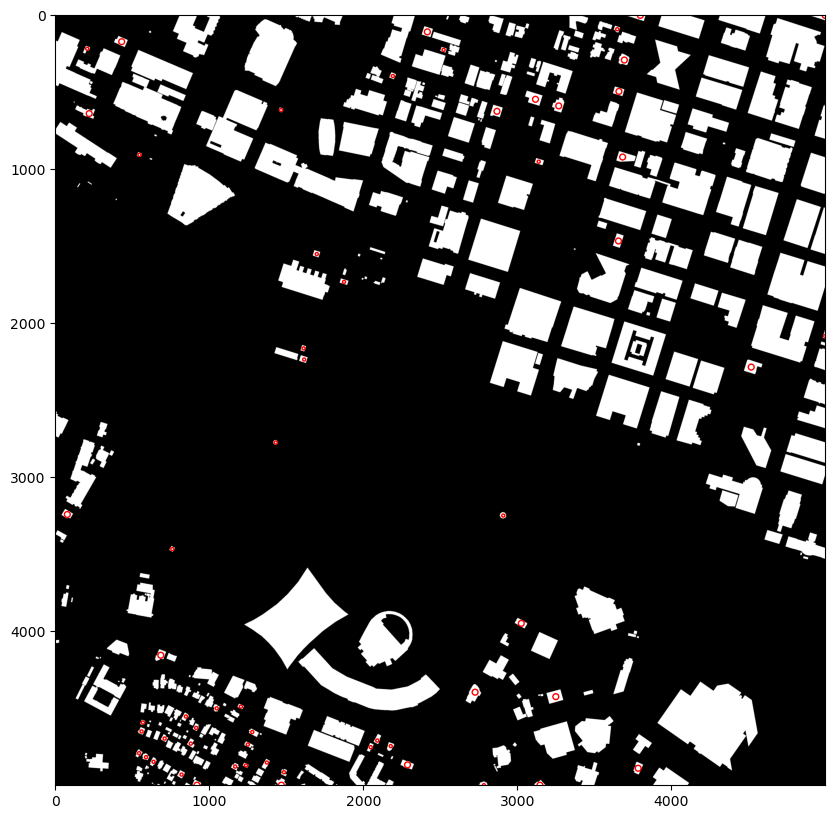

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(origin_refs[0], cmap='gray')
for blob in blobs_dog_10_200_19_04_00:
    y, x, r = blob
    # Исключим большие блобы
    if r < 30:
        c = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)
        ax.add_patch(c)
plt.show()

## 4.2. Детектирование домов на референсном изображении при помощи блобов
Оптимальные параметры функции:
* `blob_dog(image, min_sigma=10, max_sigma=200, sigma_ratio=1.9, threshold=0.4, overlap=0.0)`

In [168]:
blobs_all = []
for img in tqdm(origin_refs):
    blobs_all.append(blob_dog(img, min_sigma=10, max_sigma=200, sigma_ratio=1.9, threshold=0.4, overlap=0.0))

  0%|          | 0/5 [00:00<?, ?it/s]

Сохраним результаты детектирования локально, чтобы не надо было каждый раз вычислять блобы, т.к. это небыстрая операция.

Хранить будем в формате `json`. Формат самих записей следующий:
* `{<имя-файла-оригинального-изображения> : [<массив-всех-блобов>]}`

In [17]:
path_blobs_json = Path("./metadata/L3/blobs.json")
path_blobs_json.parent.mkdir(exist_ok=True, parents=True)

In [174]:
## ЗАПИСЬ В ФАЙЛ JSON

blobs_json_dict = {}
for name, blobs in zip(origin_names, blobs_all):
    blobs_json_dict[name] = blobs

with open(path_blobs_json, 'w') as f:
    json.dump(pickle.dumps(blobs_json_dict).decode('latin-1'), f)

In [18]:
## ЧТЕНИЕ ИЗ ФАЙЛА JSON

blobs_json_dict = {}
with open(path_blobs_json, 'r') as f:
    blobs_json_dict = pickle.loads(json.load(f).encode('latin-1'))

blobs_all = []
for name in origin_names:
    blobs_all.append(blobs_json_dict[name])

## 4.3. Создание выборки изображений крыш частных домов
Используем координаты домов, полученные при помощи блобов. Ограничим радиус блобов до `30`, чтобы большие дома не попали в выборку.

Также существуют блобы на краю изображения. Их тоже исключим в силу того, что тогда изображение будет не соответствовать размеру выбираемого окна.

In [19]:
# Ширина и высота окна
WINDOW_SIZE = 100

# Определим размер изображений, чтобы с ним сравнивать граничные значения
IMAGE_SIZE = 5000

# Обучающая выборка позитивных изображений
train_positives = []

for img_gray, img_blobs in zip(origin_gray_int, blobs_all):
    for y, x, r in img_blobs:
        # Отсеивание больших объектов
        if r > 30:
            continue

        # Вычисление граничных координат окна
        xl, xh = int(x) - WINDOW_SIZE // 2, int(x) + WINDOW_SIZE // 2
        yl, yh = int(y) - WINDOW_SIZE // 2, int(y) + WINDOW_SIZE // 2

        # Проверка граничных значений
        if xl < 0 or yl < 0 or xh > IMAGE_SIZE or yh > IMAGE_SIZE:
            continue

        # Сформировать изображение, вырезав его из изначального
        img = img_gray[yl:yh, xl:xh]
        train_positives.append(img)

print(f"Итоговое количество изображений: {len(train_positives)}.")

Итоговое количество изображений: 853.


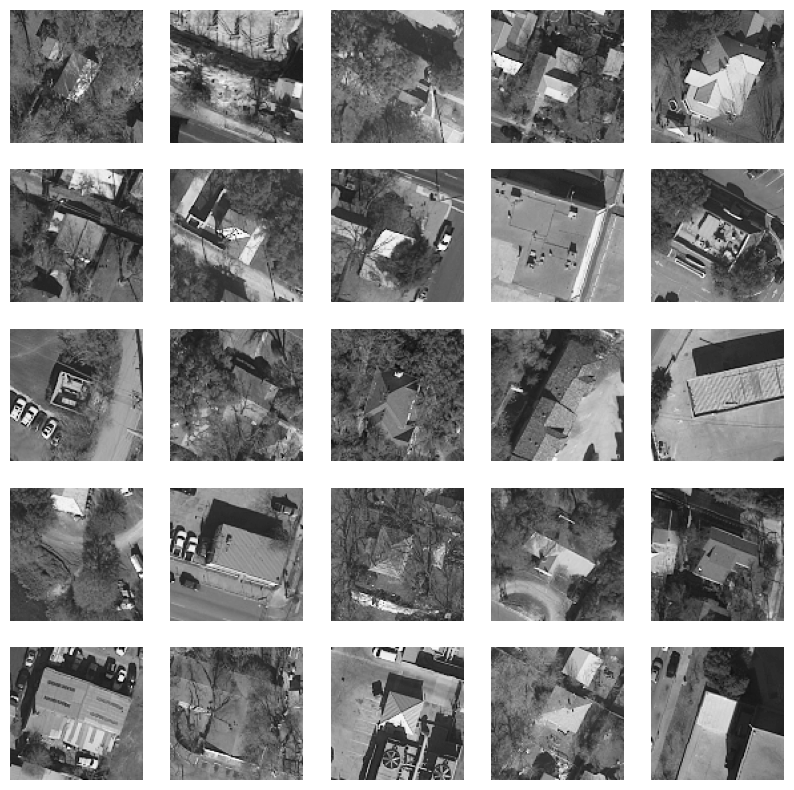

In [20]:
# Случайные 25 изображений из обучающей выборки позитивных изображений
train_samples = random.sample(train_positives, 25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for img_sample, ax in zip(train_samples, axes.flatten()):
    ax.axis('off')
    ax.imshow(img_sample, cmap='gray')

## 4.4. Создание выборки негативных изображений
Под негативными изображениями понимаются такие, которые не содержат крышу частного дома в своём центре.

Такие изображения найти проще, так как, очевидно, их центральный пиксель на референсном изображении будет чёрным. Пройдёмся по случайным пикселям референсного изображения и выберем из них чёрные. Это и будут центральные координаты окон негативных изображений.

Стоит учесть, что центральный пиксель может быть на расстоянии не менне половины ширины окна от края изображения.

In [21]:
# Обеспечение повторяемости результатов
random.seed(42)

# Обучающая выборка негативных изображений
train_negatives = []

# Параметры поиска негативных изображений
TOTAL_PIXELS_TO_CHECK = 200
LOWEST_COORDINATE     = WINDOW_SIZE // 2
HIGHEST_COORDINATE    = IMAGE_SIZE - WINDOW_SIZE // 2

for img_gray, img_ref in zip(origin_gray_int, origin_refs):
    for _ in range(TOTAL_PIXELS_TO_CHECK):
        # Выбираем случайные координаты
        x = random.randint(LOWEST_COORDINATE, HIGHEST_COORDINATE)
        y = random.randint(LOWEST_COORDINATE, HIGHEST_COORDINATE)

        # Определяем границы окна
        xl, xh = x - WINDOW_SIZE // 2, x + WINDOW_SIZE // 2
        yl, yh = y - WINDOW_SIZE // 2, y + WINDOW_SIZE // 2

        # Проверяем значение пиклеся по выбранным координатам
        if img_ref[y][x] == 0:
            train_negatives.append(img_gray[yl:yh, xl:xh])

print(f"Итоговое количество изображений: {len(train_negatives)}.")

Итоговое количество изображений: 845.


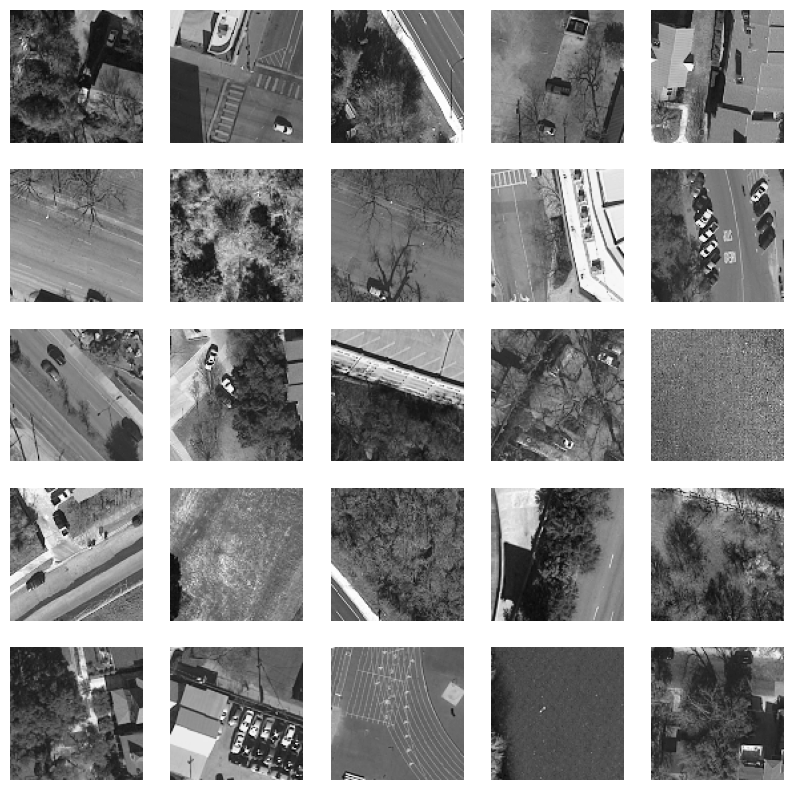

In [22]:
# Случайные 25 изображений из обучающей выборки негативных изображений
train_samples = random.sample(train_negatives, 25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for img_sample, ax in zip(train_samples, axes.flatten()):
    ax.axis('off')
    ax.imshow(img_sample, cmap='gray')

## 4.5. Объединение всех изображений в общую выборку
Нужно теперь объединить позитивную и негативную части выборки в формат пар `(X, y)`.

In [23]:
train = []

for img in train_positives:
    train.append((img, 1))

for img in train_negatives:
    train.append((img, 0))

print(f"Итоговый размер всей тестовой выборки: {len(train)}")

Итоговый размер всей тестовой выборки: 1698


Возможно, будет также удобно разделить выборки на `data` и `target` отдельно.

In [24]:
data   = []
target = []

for X, y in train:
    data.append(X)
    target.append(y)

# Приведём к типу np.ndarray
data   = np.array(data)
target = np.array(target)

# 5. Создание классификатора
Классификатор будет основан на каскадах характерных признаков Хаара и обучен при помощи алгоритма [Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

## 5.1. Создание признаков Хаара
Для начала, следует, исходя из размеров окна, создать все возможные характерные признаки Хаара. Признаки будут храниться следующим образом:
* `[[<список положительных обрластей>], [<список отрицательных обрластей>]]`

Области определяются координатами верхнего левого угла и правого нижнего в формате:
* `[(<верхняя левая координата Y>, <верхняя левая координата X>), (<нижняя правая координата Y>, <нижняя правая координата X>)]`

Выберем 3 вида признаков хаара:
* Горизонтальный из двух областей;
* Вертикальный из двух областей;
* Диагональный из четырёх областей.

Координаты определяются следующим образом:
```
Горизонтальный признак:
*-------------------------------------------*
|(yl, xl)                                   |
|                                           |
|                                           |
|                                           |
|                                   (yc, xh)|
*-------------------------------------------*
|(yc + 1, xl)                               |
|                                           |
|                                           |
|                                           |
|                                   (yh, xh)|
*-------------------------------------------*

Вертикальный признак:
*---------------------*---------------------*
|(yl, xl)             |(yl, xc + 1)         |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|                     |                     |
|             (yh, xc)|             (yh, xh)|
*---------------------*---------------------*

Диагональный признак:
*---------------------*---------------------*
|(yl, xl)             |(yl, xc + 1)         |
|                     |                     |
|                     |                     |
|                     |                     |
|             (yc, xc)|             (yc, xh)|
*---------------------*---------------------*
|(yc + 1, xl)         |(yc + 1, xc + 1)     |
|                     |                     |
|                     |                     |
|                     |                     |
|             (yh, xc)|             (yh, xh)|
*---------------------*---------------------*
```
Также стоит учесть, что при вычислении области в признаке Хаара в качестве меньших координат берутся не координаты внутри обрасти, а на одну координату меньше. Например, для вычисления области с координатами `(yl, xl)` и `(yh, xh)` необходимо сложить пиксели с координатами `(yl - 1, xl - 1)` и `(xh, yh)` и вычесть пиксели с координатами `(yl - 1, xh)` и `(yh, xl - 1)`.

Для каждого из признаков будут два варианта, отличающиеся только противоположным статусом областей. Например:
```
[[1, -1]   и  [[-1, 1]
 [1, -1]]      [-1, 1]]
```

Минимальный размер признака установим равным 2х2, чтобы все виды признаков имели полноценные области и не вырождались в более тривиальные.

В ходе попыток создания признаков стало очевидно, что при текущих значениях параметров координат и размеров окна получается слишком много признаков, поэтому ограничим подбор признаков ещё сильнее:
* Качество изображения внутри окна будет уменьшаться в 5 раз по каждому линейному размеру;
* Линейный размер признака не менее 2;
* Линейный размер признака не больше всего окна (т.е. тут без изменений);
* Шаг размера признака равен 2;
* Шаг координат признака равен 2.

In [25]:
# Список всех признаков
haar_features = []

# Параметры поиска признаков Хаара
SCALE_FACTOR     = 5
HAAR_WINDOW_SIZE = WINDOW_SIZE // SCALE_FACTOR
HAAR_SIZE_MIN    = 2
HAAR_SIZE_MAX    = HAAR_WINDOW_SIZE + 1    # Используется для координат, поэтому верхняя граница должна быть включена
HAAR_SIZE_STEP   = 2
HAAR_COORD_SPEP  = 2

# Размеры признака
for width in tqdm(range(HAAR_SIZE_MIN, HAAR_SIZE_MAX, HAAR_SIZE_STEP)):
    for height in range(HAAR_SIZE_MIN, HAAR_SIZE_MAX, HAAR_SIZE_STEP):
        # Координаты признака yl (y_low) и xl (x_low)
        for yl in range(0, HAAR_WINDOW_SIZE - height + 1, HAAR_COORD_SPEP):
            for xl in range(0, HAAR_WINDOW_SIZE - width + 1, HAAR_COORD_SPEP):
                # Координаты правого нижнего края признака yh (y_high) и xh(x_high)
                yh, xh = yl + height - 1, xl + width - 1

                # Горизонтальный признак из двух областей
                # Центральная координата yc (y_central)
                for yc in range(yl, yh):
                    feature = [
                        [[(yl - 1, xl - 1), (yc, xh)]], # положительные области
                        [[(yc, xl - 1), (yh, xh)]], # отрицательные области
                    ]
                    feature_r = list(reversed(feature))
                    haar_features.append(feature)
                    haar_features.append(feature_r)

                # Веритикальный признак из двух областей
                # Центральная координата xc (x_central)
                for xc in range(xl, xh):
                    feature = [
                        [[(yl - 1, xl - 1), (yh, xc)]], # положительные области
                        [[(yl - 1, xc), (yh, xh)]], # отрицательные области
                    ]
                    feature_r = list(reversed(feature))
                    haar_features.append(feature)
                    haar_features.append(feature_r)

                # Диагональный признак
                # Центральные координаты xc (x_central) и yc (y_central)
                for yc in range(yl, yh):
                    for xc in range(xl, xh):
                        feature = [
                            [[(yl - 1, xl - 1), (yc, xc)], [(yc, xc), (yh, xh)]], # положительные области
                            [[(yc, xl - 1), (yh, xc)], [(yl - 1, xc), (yc, xh)]], # отрицательные области
                        ]
                        feature_r = list(reversed(feature))
                        haar_features.append(feature)
                        haar_features.append(feature_r)

print(f"Итоговое количество признаков: {len(haar_features)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Итоговое количество признаков: 381150


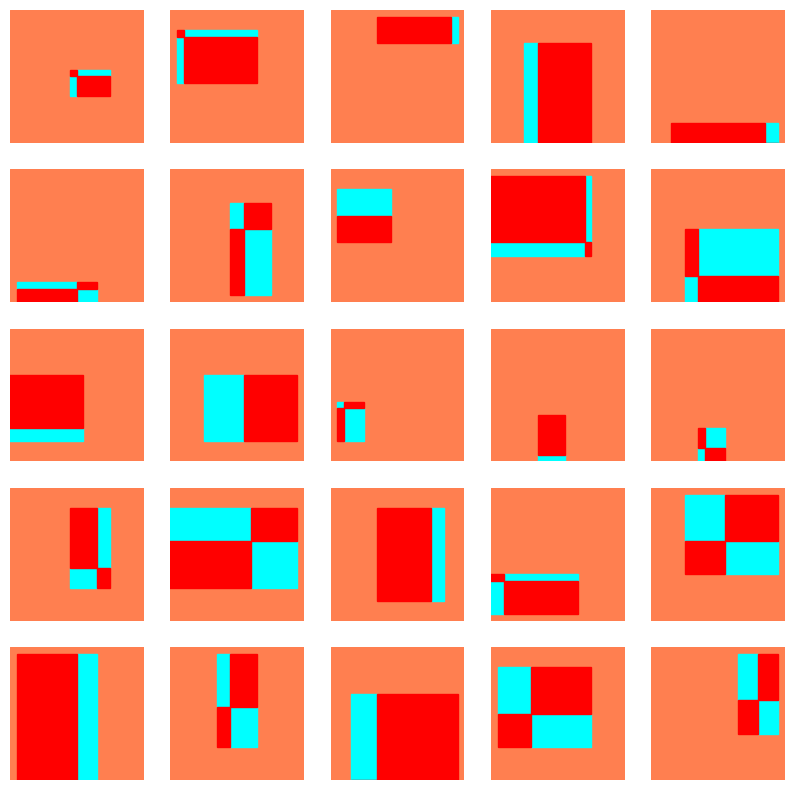

In [26]:
# Случайные 25 изображений из обучающей выборки негативных изображений
feature_samples = random.sample(haar_features, 25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for feat, ax in zip(feature_samples, axes.flatten()):
    ax.axis('off')
    r = plt.Rectangle((0, 0), 1, 1, color='coral')
    ax.add_patch(r)
    
    # Положительные области
    for area in feat[0]:
        r = plt.Rectangle((area[0][1] / HAAR_WINDOW_SIZE, area[0][0] / HAAR_WINDOW_SIZE), (area[1][1] - area[0][1]) / HAAR_WINDOW_SIZE, (area[1][0] - area[0][0]) / HAAR_WINDOW_SIZE, color='cyan')
        ax.add_patch(r)
    
    # Отрицательные области
    for area in feat[1]:
        r = plt.Rectangle((area[0][1] / HAAR_WINDOW_SIZE, area[0][0] / HAAR_WINDOW_SIZE), (area[1][1] - area[0][1]) / HAAR_WINDOW_SIZE, (area[1][0] - area[0][0]) / HAAR_WINDOW_SIZE, color='red')
        ax.add_patch(r)

Приведём каждый признак к виду, при котором его будет проще вычислять. Вместо координат углов будм хранить массивы координат, которые надо сложить с результатом, и координаты, которые надо вычесть из результата в следующем виде:
* `[[<Координаты на сложение в формате (y, x)>], [<Координаты на вычитание в формате (y, x)>]]`

In [27]:
haar_feats_coords = []

for feat in tqdm(haar_features):
    # Координаты, которые будут сложены с результатом
    positive_coords = []
    # Координаты, которые будут вычтены из результата
    negative_coords = []

    # Положительнные области
    for (yl, xl), (yh, xh) in feat[0]:
        # В силу специфики записи координат, координаты могут быть отрицательными.
        # Это означает, что эти координаты просто не надо вычислять,
        # потому что все координаты вне изображения они равны нулю.
        if yl >= 0 and xl >= 0:
            positive_coords.append((yl, xl))
        if yl >= 0:
            negative_coords.append((yl, xh))
        if xl >= 0:
            negative_coords.append((yh, xl))
        positive_coords.append((yh, xh))

    # Отрицательные области
    for (yl, xl), (yh, xh) in feat[1]:
        # В силу специфики записи координат, координаты могут быть отрицательными.
        # Это означает, что эти координаты просто не надо вычислять,
        # потому что все координаты вне изображения равны нулю.
        if yl >= 0 and xl >= 0:
            negative_coords.append((yl, xl))
        if yl >= 0:
            positive_coords.append((yl, xh))
        if xl >= 0:
            positive_coords.append((yh, xl))
        negative_coords.append((yh, xh))

    # Исключим те координаты, которые одновременно и отнимаются, и складываются
    new_pos = []
    new_neg = negative_coords.copy()

    for coords in positive_coords:
        if coords in negative_coords:
            new_neg.remove(coords)
        else:
            new_pos.append(coords)

    haar_feats_coords.append([new_pos, new_neg])

  0%|          | 0/381150 [00:00<?, ?it/s]

## 5.2. Реализация алгоритма Adaboost
Алгоритм будет реализован в соответствии с этой [статьёй](https://ieeexplore.ieee.org/document/990517).

In [28]:
class AdaBoost:
    """
    Данный класс реализует алгоритм AdaBoost в соответствии со статьёй:
        https://ieeexplore.ieee.org/document/990517
    """
    def __init__(self, haar_feats_coords=None, haar_count=None, n_weak_classifiers=50, threshold=0, scale_factor=1, random_state=42, integral_trainsform_required=True):
        """
        Основной конструктор класса.
    
        Параметры
        ---------
        haar_feats_coords : list
            Список признаков Хаара, содержащий списки коррдинат, которые
            необходимо пибавить к результату и вычесть из него (см. пояснения ранее).
        haar_count : int
            Количество признаков, случайно выбираемое из списка haar_feats_coords,
            и которое используется в обучении. Сделано это для того, чтобы при
            слишком большом списке изначальных признаков не затягивать процессс
            обучения в ущерб его качеству.
                Если None, то ограничение не применяется и используются
                все переданные признаки Хаара.
        n_weak_classifiers : int
            Количество слабых классификаторов, которые необходимо выбрать в ходе обучения.
        threshold : int, float
            Пороговое значение срабатывания слабых классификаторов, используемое при обучении.
        scale_factor : int
            Степень снижения качества изображения.
        random_state : int
            Семя случайностй, используемое при выборе признаков из общего списка характерных признаков Хаара.
        integral_trainsform_required : boolean
            Требуется ли преобразовывать входные изображения в интегральные.
        """
        self.haar_feats_coords  = haar_feats_coords
        self.haar_count         = haar_count
        self.n_weak_classifiers = n_weak_classifiers
        self.threshold          = threshold
        self.scale_factor       = scale_factor
        self.random_state       = random_state
        self.integral_trainsform_required = integral_trainsform_required

    def fit(self, X : np.ndarray, y : np.ndarray):
        """
        Данная функция выполняет отбор слабых классификаторов.

        Параметры
        ---------
        X : np.ndarray
            Массив изображений обучающей выборки.
        y : np.ndarray
            Массив меток обучающей выборки.
        """
        # Обработка входных значений
        X_rescaled = np.array([rescale(x, 1 / self.scale_factor) for x in X])
        X_integral = np.apply_over_axes(np.cumsum, X_rescaled, [1, 2]) if self.integral_trainsform_required else X_rescaled
        num_pos    = np.sum(y)
        num_neg    = len(y) - num_pos

        # Инициализация переменных для обучения
        self.weak_classifiers = []
        self.alpha = np.zeros(self.n_weak_classifiers)
        sample_weights = np.array([0.5 / num_pos if target else 0.5 / num_neg for target in y])

        # Выбор признаков, на которых будет проводиться обучение
        random.seed(self.random_state)
        if self.haar_count is None or self.haar_count > len(self.haar_feats_coords):
            haar_feats = self.haar_feats_coords
            self.haar_count = len(self.haar_feats_coords)
        else:
            haar_feats = random.sample(self.haar_feats_coords, self.haar_count)

        # Маска уже добавленных классификаторов
        weak_mask = np.full(self.haar_count, False)

        # непосредственно сам алгоритм обучения
        for n in tqdm(range(self.n_weak_classifiers)):
            sample_weights /= np.sum(sample_weights)
            
            error = np.zeros(self.haar_count)
            # Применение характерных признаков
            for idx, feat in enumerate(haar_feats):
                res = self._calculate_feature(X_integral, feat)
                y_preds = (res > self.threshold).astype(np.int32)
                error[idx] = np.sum(sample_weights * np.abs(y_preds - y))

            # Добавление нового слабого классификатора
            error[weak_mask] = np.inf # Исключим из "гонки" те признаки, которые уже выбраны
            weak_index = np.argmin(error)
            self.weak_classifiers.append(haar_feats[weak_index])
            weak_mask[weak_index] = True
            
            # Перерасчёт весов
            best_error = error[weak_index]
            beta = best_error / (1 - best_error)
            self.alpha[n] = np.log(1 / beta)

            res = self._calculate_feature(X_integral, haar_feats[weak_index])
            y_preds = (res > self.threshold).astype(np.int32)
            correctly_classified = (y == y_preds).astype(np.int32)
            sample_weights = sample_weights * np.power(beta, correctly_classified)

        self.weak_thresholds = np.full(len(self.weak_classifiers), self.threshold)

    def predict(self, X, integral_trainsform_required = True):
        """
        Данная функция выполняет классификацию входных данных.

        Параметры
        ---------
        X : np.ndarray
            Массив изображений для классификации.

        Возвращаемое значение
        ---------------------
        y_preds : np.ndarray
            Массив меток, классифицирующих переданные изображения.
        """
        X_rescaled = np.array([rescale(x, 1 / self.scale_factor) for x in X])
        X_integral = np.apply_over_axes(np.cumsum, X_rescaled, [1, 2]) if self.integral_trainsform_required else X_rescaled

        alpha_sum = 0.5 * np.sum(self.alpha)
        alpha_voted = np.zeros(X_integral.shape[0])
        for alpha_t, feat, threshold in zip(self.alpha, self.weak_classifiers, self.weak_thresholds):
            alpha_voted[self._calculate_feature(X_integral, feat) > threshold] += alpha_t
        y_preds = (alpha_voted >= alpha_sum).astype(np.int32)

        return y_preds

    def save(self, path : Path):
        """
        Данная функция выполняет сохранение параметров модели в обозначенную папку.

        Параметры
        ---------
        path : pathlib.Path
            Путь до папки, которая используется для хранения моделей.
        """
        path.mkdir(parents=True, exist_ok=True)

        # Определим № модели
        file_id = 1
        for file_path in path.iterdir():
            if file_path.is_dir():
                continue
            
            # Все имена файлов имеют формат haar_<№ модели>.pkl
            # Достанем из названия № модели
            model_id = int(file_path.name[5:-4])
            if model_id >= file_id:
                file_id = model_id + 1
    
        model_dict = {
            'weak_classifiers' : self.weak_classifiers,
            'weak_thresholds'  : self.weak_thresholds,
            'alpha'            : self.alpha,
    
            'haar_feats_coords'  : self.haar_feats_coords,
            'haar_count'         : self.haar_count,
            'n_weak_classifiers' : self.n_weak_classifiers,
            'threshold'          : self.threshold,
            'scale_factor'       : self.scale_factor,
            'random_state'       : self.random_state,
            'integral_trainsform_required' : self.integral_trainsform_required,
        }
    
        file_path = path / f"haar_{file_id}.pkl"
        with open(file_path, 'wb') as f:
           pickle.dump(model_dict, f)

        print(f"Файл сохранён по пути: {file_path}")

    def load(self, file_path : Path):
        """
        Данная функция выполняет загрузку параметров модели из обозначенного файла.

        Параметры
        ---------
        file_path : pathlib.Path
            Путь до файла с параметрами модели.

        Возвращаемое значение
        ---------------------
        y_preds : np.ndarray
            Массив меток, классифицирующих переданные изображения.
        """
        model_dict = {}
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)

        for key in model_dict:
            self.__dict__[key] = model_dict[key]

    def _calculate_feature(self, X_integral, feat):
        """
        Данная функция вычисляет значение характерного признака Хаара.

        Параметры
        ---------
        X_integral : np.ndarray
            Массив изображений для классификации в интегральном виде.
        feat : list
            Характерный признак Хаара в формате, описанном ранее.

        Возвращаемое значение
        ---------------------
        res : np.ndarray
            Массив значений характерных признаков Хаара для всех переданных изображений.
        """
        res = np.zeros(X_integral.shape[0])
        
        # Обработка позитивных координат
        for pos in feat[0]:
            res += X_integral[:, pos[0], pos[1]]
            
        # Обработка отрицательных координат
        for neg in feat[1]:
            res -= X_integral[:, pos[0], pos[1]]
    
        return res

## 5.3. Применение алгоритма Adaboost
В данном разделе обучим и сохраним модели с разным количеством признаков. в этом же разделе можно прочитать модели из памяти, чтобы не переобучать их заново.

In [85]:
model = AdaBoost(haar_feats_coords=haar_feats_coords, haar_count=None, n_weak_classifiers=2, threshold=0, scale_factor=SCALE_FACTOR, random_state=42, integral_trainsform_required=True)
model.fit(data, target)

  0%|          | 0/2 [00:00<?, ?it/s]

In [196]:
y_preds = model.predict(data, True)
print(f"Точность составляет: {sum(y_preds == target) / len(target)}")

Точность составляет: 0.8345111896348646


### 5.3.1. Работа с файлами

In [29]:
models_path = Path("./models/L3")

In [197]:
# ЗАПИСЬ МОДЕЛИ В ФАЙЛ

model.save(models_path)

Файл сохранён по пути: models\L3\haar_7.pkl


In [195]:
# ЧТЕНИЕ МОДЕЛИ ИЗ ФАЙЛА

# Идентификатор модели в имени файла
MODEL_ID = 1

model = AdaBoost()
model_file = models_path / f"haar_{MODEL_ID}.pkl"
model.load(model_file)

# 6. Анализ результатов
* Оценим точность модели в зависимости от количества характерных признаков Хаара.
* Оценим на самой большой модели зависимость ошибок перввого и второго рода в зависимости от порога срабатывания Характерных признаков Хаара.
* Проведём детектирование домов на спутниковом изображении.

## 6.1. Общие метрики

In [30]:
# Считаем все модели из файлов
models = []
for model_path in models_path.iterdir():
    if not model_path.is_file():
        continue
    model = AdaBoost()
    model.load(model_path)
    models.append(model)

print(f"Всего прочитано моделей: {len(models)}")

Всего прочитано моделей: 6


In [31]:
# вычислим точность в зависимости от количества признаков
models_count = len(models)
precision  = np.zeros(models_count)
feat_count = np.zeros(models_count)

for idx, model in enumerate(models):
    y_preds = model.predict(data, True)
    precision[idx]  = sum(y_preds == target) / len(target)
    feat_count[idx] = len(model.weak_classifiers)

# Выделим самую большую модель
biggest_model = models[np.argmax(feat_count)]

# Упорядочим по возрастанию количества признаков
precision = precision[feat_count.argsort()]
feat_count.sort()

In [32]:
# Рассчитаем для самой большой модели ошибки первого и второго рода в зависимости от порога
NUM_TESTS = 50
THRESHOLD_MIN = -10
THRESHOLD_MAX = 10

# Ошибки первого и второго рода (в процентном соотношении к общему размеру тестовой выборки)
error_first  = np.zeros(NUM_TESTS)
error_second = np.zeros(NUM_TESTS)
num_targets = len(target)

thresholds = np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NUM_TESTS)
for idx, threshold in enumerate(thresholds):
    biggest_model.weak_thresholds = np.full_like(biggest_model.weak_thresholds, threshold)
    y_preds = biggest_model.predict(data)
    error_first[idx]  = np.sum(y_preds > target) / num_targets
    error_second[idx] = np.sum(y_preds < target) / num_targets

# Вернём порог срабатывания обратно к нулю
biggest_model.weak_thresholds = np.full_like(biggest_model.weak_thresholds, 0)

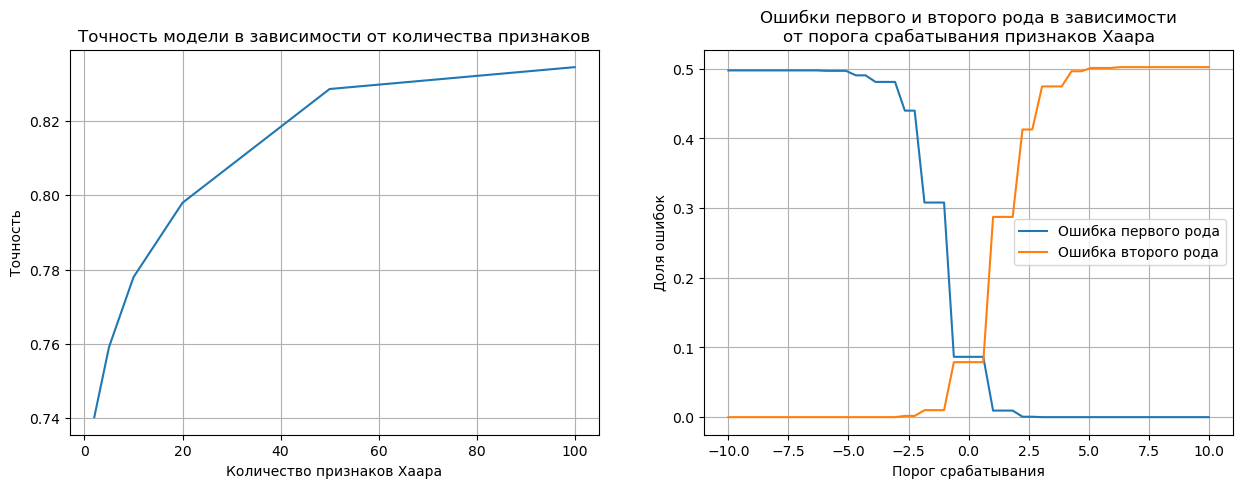

In [33]:
# Отобразим общие метрики
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Зависимость точности от количества признаков
axes[0].plot(feat_count, precision)
axes[0].grid()
axes[0].set_title("Точность модели в зависимости от количества признаков")
axes[0].set_xlabel("Количество признаков Хаара")
axes[0].set_ylabel("Точность")

# Зависимость ошибок первого и второго рода от порога срабатывания признаков Хаара
axes[1].plot(thresholds, error_first, label="Ошибка первого рода")
axes[1].plot(thresholds, error_second, label="Ошибка второго рода")
axes[1].grid()
axes[1].legend()
axes[1].set_title("Ошибки первого и второго рода в зависимости\nот порога срабатывания признаков Хаара")
axes[1].set_xlabel("Порог срабатывания")
axes[1].set_ylabel("Доля ошибок")

plt.show()

## 6.2. Пример применения классификатора на изображении

In [34]:
random.seed(42)
test_image = random.sample(origin_gray_int, 1)[0]
img_shape = test_image.shape

COORD_STEP = 50

# Повысим порог срабатывания
biggest_model.weak_thresholds = np.full_like(biggest_model.weak_thresholds, 2.5)

detected_houses = []
for y_coord in tqdm(range(0, img_shape[0] - WINDOW_SIZE, COORD_STEP)):
    for x_coord in range(0, img_shape[1] - WINDOW_SIZE, COORD_STEP):
        window = test_image[y_coord : y_coord + WINDOW_SIZE, x_coord : x_coord + WINDOW_SIZE]
        prediction = biggest_model.predict(np.expand_dims(window, axis=0))[0]
        if prediction:
            detected_houses.append((y_coord, x_coord))

print(f"Найдено домов: {len(detected_houses)}")

  0%|          | 0/98 [00:00<?, ?it/s]

найдено домов: 161


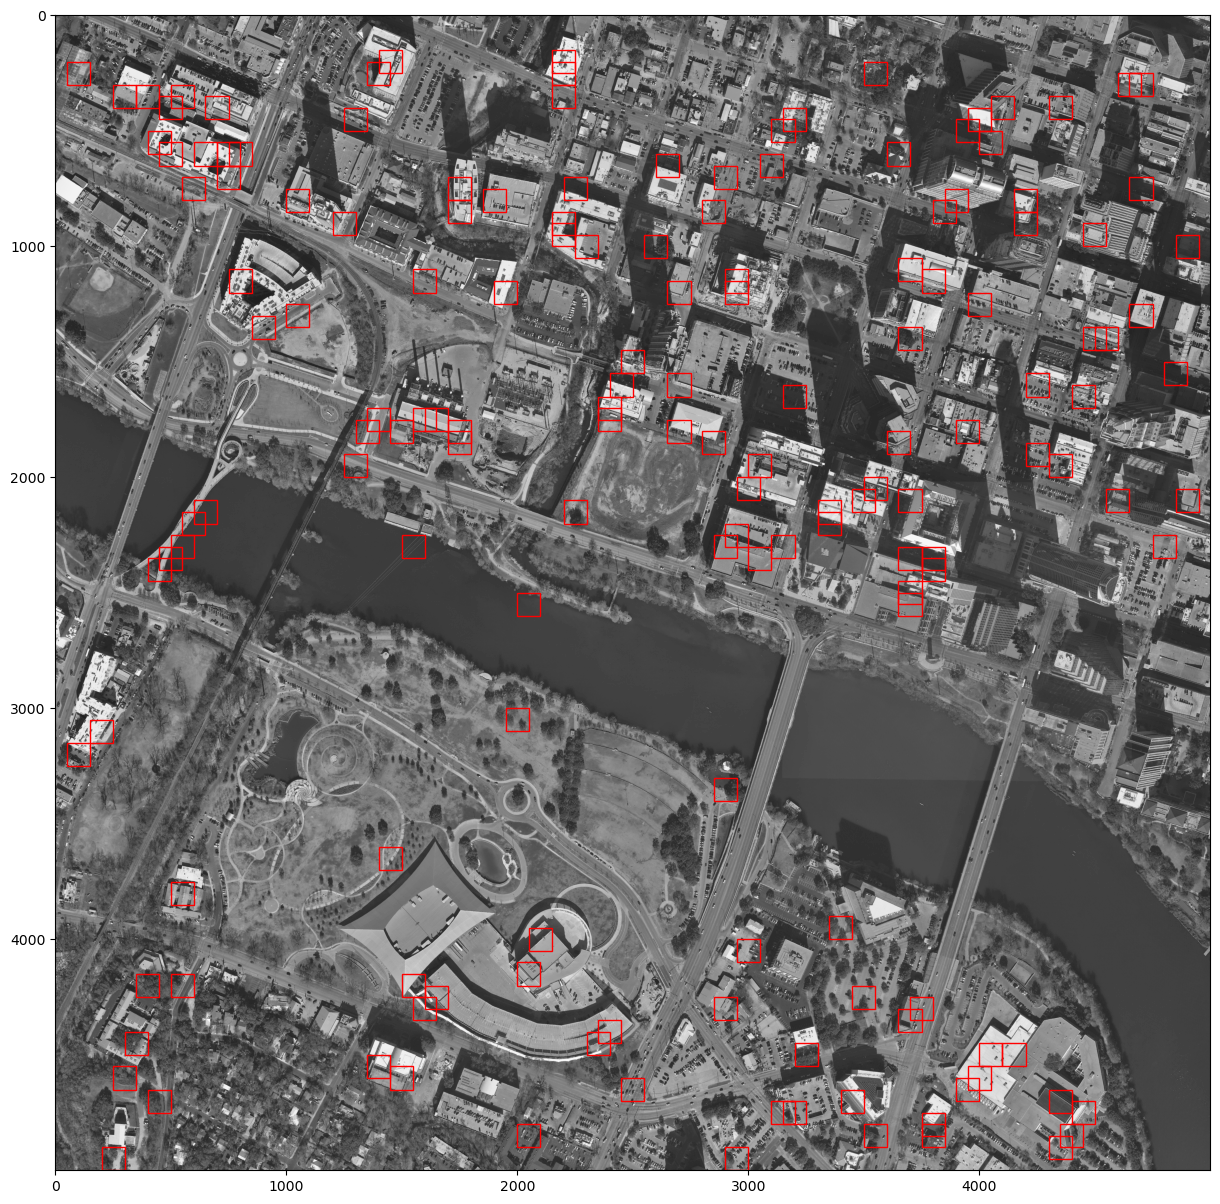

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(test_image, cmap='gray')
for y, x in detected_houses:
    rect = plt.Rectangle((x, y + WINDOW_SIZE), WINDOW_SIZE, WINDOW_SIZE, color='red', fill=False)
    ax.add_patch(rect)

plt.show()

На реальных данных классификатор работает плохо. Возможно, следует увеличить количество признаков и сделать каскад признаков, а не выполнять только одно "голосование".